# <div align=center>回归分析方法</div>

In [1]:
from scipy import linspace, polyval, polyfit, sqrt, stats, randn, optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd

import warnings
 
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 读取保险数据 1337 X 7
df_all_insur = pd.read_csv('~/Datasets/Statistics/insurance.csv')
df_all_insur[-10:]

,age,sex,bmi,children,smoker,region,charges
1328,23,female,24.225,2,no,northeast,22395.74424
1329,52,male,38.600,2,no,southwest,10325.20600
1330,57,female,25.740,2,no,southeast,12629.16560
1331,23,female,33.400,0,no,southwest,10795.93733
1332,52,female,44.700,3,no,southwest,11411.68500
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500
1337,61,female,29.070,0,yes,northwest,29141.36030


In [3]:
# 分成男/女两组
grp_by_sex = df_all_insur.groupby(by='sex')
grp_by_sex_to_dict = dict(list(grp_by_sex))
df_male_insur = grp_by_sex_to_dict['male']
df_female_insur = grp_by_sex_to_dict['female']

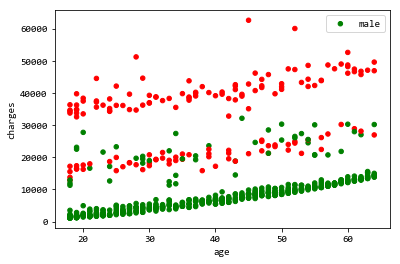

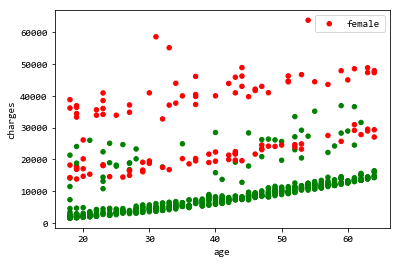

In [4]:
# 年龄和保险额之间的闪点图(红色是吸烟)
df_male_insur.plot.scatter(
    'age', 'charges',
    c=['g' if x else 'r' for x in df_male_insur.smoker == 'no'],
    label='male')

df_female_insur.plot.scatter(
    'age', 'charges',
    c=['g' if x else 'r' for x in df_female_insur.smoker == 'no'],
    label='female')

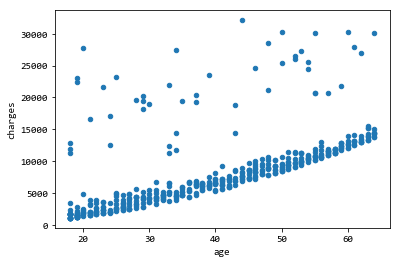

In [5]:
# 吸烟对保险额影响不小, 暂时去掉
df_male_insur_no_smoker = df_male_insur[df_male_insur.smoker == 'no']
df_male_insur_no_smoker.plot.scatter('age', 'charges')
# 从图可以了解到除了年龄, 还有其他因素影响

# 方法1: scipy.polytfit

In [6]:
nd_r_d1 = polyfit(df_male_insur_no_smoker['age'], df_male_insur_no_smoker['charges'], deg=1)
nd_r_d1

array([  264.93170273, -2261.52976897])

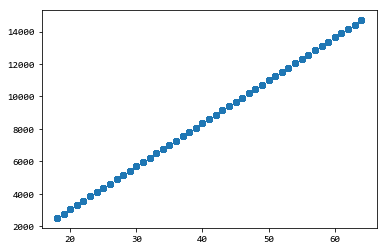

In [7]:
nd_r_charges_by_age = polyval(nd_r_d1, df_male_insur_no_smoker['age'])
plt.scatter(df_male_insur_no_smoker['age'], nd_r_charges_by_age)

# 方法2:scipy.stats.linregress

In [8]:
lr_result = stats.linregress(df_male_insur_no_smoker['age'], df_male_insur_no_smoker['charges'])
lr_result 

LinregressResult(slope=264.9317027297566, intercept=-2261.529768969891, rvalue=0.6345493898059457, pvalue=1.319799944565052e-59, stderr=14.219301240416462)

In [9]:
# plt.scatter(
#     df_male_insur_no_smoker['age'],
#     polyval((lr_result.slope, lr_result.intercept), df_male_insur_no_smoker['age'])
# )

# 方法3: curve_fit

In [10]:
def fcall(x, a, b):
    return (a*x + b);
tup_result = optimize.curve_fit(
    f=fcall,
    xdata = df_male_insur_no_smoker['age'],
    ydata = df_male_insur_no_smoker['charges'],
    method = 'lm'
)
tup_result

(array([  264.93170513, -2261.52982725]),
 array([[ 2.02188524e+02, -7.89786714e+03],
        [-7.89786714e+03,  3.48914441e+05]]))

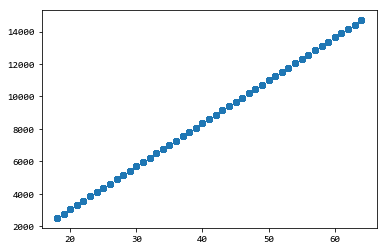

In [11]:
plt.scatter(
    df_male_insur_no_smoker['age'],
    [fcall(x, tup_result[0][0], tup_result[0][1]) for x in df_male_insur_no_smoker['age']]
)

# 方法4: numpy.linalg.lstsq

In [12]:
# B = Ax : x = (a, b)
# df_male_insur_no_smoker['age'].size, df_male_insur_no_smoker.index.size # size一样
# df_male_insur_no_smoker['age'].size, df_male_insur_no_smoker.size # size 不一样
A = np.vstack((df_male_insur_no_smoker['age'], np.ones(df_male_insur_no_smoker['age'].size))).T
A[0:5]

array([[18.,  1.],
       [28.,  1.],
       [33.,  1.],
       [32.,  1.],
       [37.,  1.]])

In [13]:
tup_result = np.linalg.lstsq(a = A, b = df_male_insur_no_smoker['charges'], rcond=None)
tup_result 

(array([  264.93170273, -2261.52976897]),
 array([1.07590379e+10]),
 2,
 array([944.79529816,   7.73592762]))

# 方法5: statsmodels.OLS

In [14]:
X = sm.add_constant(df_male_insur_no_smoker['age'], prepend=False) # prepend=False, 常数1追加到列的后面
X[0:5]

,age,const
1,18,1.0
2,28,1.0
3,33,1.0
4,32,1.0
8,37,1.0


In [15]:
ols_model = sm.OLS(endog=df_male_insur_no_smoker['charges'], exog=X)
ols_result = ols_model.fit()
ols_result.params 

age       264.931703
const   -2261.529769
dtype: float64

In [16]:
ols_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.401     
Dependent Variable: charges          AIC:                10183.1335
Date:               2018-12-10 20:04 BIC:                10191.6296
No. Observations:   517              Log-Likelihood:     -5089.6   
Df Model:           1                F-statistic:        347.1     
Df Residuals:       515              Prob (F-statistic): 1.32e-59  
R-squared:          0.403            Scale:              2.0891e+07
--------------------------------------------------------------------
         Coef.     Std.Err.     t     P>|t|     [0.025      0.975]  
--------------------------------------------------------------------
age      264.9317   14.2193  18.6318  0.0000    236.9967    292.8667
const  -2261.5298  590.6898  -3.8286  0.0001  -3421.9877  -1101.0718
-------------------------------------------------------------------
Omnibus:             352.872       Durbin-Watson:          2.012   
Prob(Omnibus):       0.000         Jarque-Bera (JB):       2661.799
Skew:                3.138         Prob(JB):               0.000   
Kurtosis:            12.175        Condition No.:          122     
===================================================================

"""

# 方法6: 求伪逆矩阵

In [17]:
A = np.vstack((df_male_insur_no_smoker['age'], np.ones(df_male_insur_no_smoker['age'].size))).T
# 摩尔－彭若斯广义逆, ( Moore-Penrose pseudo inverse)
A_inv = np.linalg.pinv(A)
result = A_inv.dot(df_male_insur_no_smoker['charges'])
result

array([  264.93170273, -2261.52976897])

# 方法7: 求矩阵的逆

Ax = B -> $(A^TA)^{-1}x = (A^TA)^{-1}A^TB$


In [18]:
result = np.dot((np.dot(np.linalg.inv(np.dot(A.T, A)), A.T)), df_male_insur_no_smoker['charges'])
result

array([  264.93170273, -2261.52976897])

# 方法8: sklearn.linear_model.LinearRegression

In [19]:
lm = LinearRegression()
lm.fit(A, df_male_insur_no_smoker['charges'])
lm.coef_, lm.intercept_

(array([264.93170273,   0.        ]), -2261.5297689698964)